<a href="https://colab.research.google.com/github/thomouvic/txtanalytics/blob/main/CreateDFforHSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!wget https://github.com/thomouvic/txtanalytics/raw/main/txts.zip
!unzip -oq txts.zip

--2022-11-27 15:24:05--  https://github.com/thomouvic/txtanalytics/raw/main/txts.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thomouvic/txtanalytics/main/txts.zip [following]
--2022-11-27 15:24:06--  https://raw.githubusercontent.com/thomouvic/txtanalytics/main/txts.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3274958 (3.1M) [application/zip]
Saving to: ‘txts.zip.3’

txts.zip.3          100%[===================>]   3.12M  --.-KB/s    in 0.08s   

2022-11-27 15:24:07 (37.5 MB/s) - ‘txts.zip.3’ saved [3274958/3274958]



In [5]:
# Retrieve the filenames.

from pathlib import Path

all_filenames =[]
for file in Path("./txts/").rglob("*.txt"):
  # print(file)
  all_filenames.append(file.parent / file.name)

all_filenames.sort()

print( len(all_filenames) )
# print(all_filenames)

130


In [6]:
# Create a pandas dataframe with docname and text as columns.  

import pandas as pd

all_docs = [open(f).read() for f in all_filenames]

# A: store docnames to a pandas frame, then to a csv file
df = pd.DataFrame({'docname':all_filenames, 'text': all_docs})
df['docid'] = df.index
df.to_csv('docs.csv', index=False)

# print(df.iloc[0,0], df.iloc[0,1])

In [7]:
df['length'] = df['text'].str.len()

df[ ['length'] ].describe().T

,count,mean,std,min,25%,50%,75%,max
length,130.0,70928.215385,146387.165565,1.0,22894.0,36793.0,61917.25,1219398.0


<Figure size 576x144 with 0 Axes>

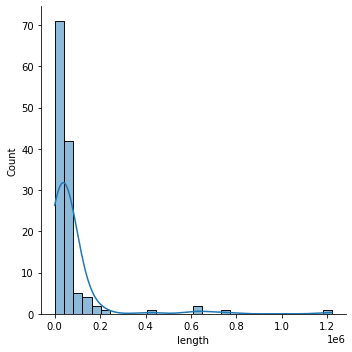

In [8]:
# Not in book: seaborn plot with gaussian kernel density estimate
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
sns.displot(df['length'], bins=30, kde=True);

# The histogram shows the distribution of the document lengths in HSS Commons. 
# We see that many docs are are less than 0.1*10^6 characters long.  
# The average English word is 4.7 characters long. 
# So, we have that many docs are are less than 0.1*10^6/4.7 = 21,276 words long. 
# Few docs are quite long. See the tail of the distribution. One of these docs
# is conference proceedings, Abstract.txt   

# Blueprint: Building a Simple Text Preprocessing Pipeline

## Tokenization with Regular Expressions

In [9]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [10]:
# This is just a small usage example.

text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


In [11]:
import nltk
# not in book: make sure stop words are available
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

## Processing a Pipeline with one Line of Code

In [13]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [14]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

In [59]:
# keeping only tokens with length >= 4
df['tokens'] = df['tokens'].apply(lambda li : [x for x in li if len(x)>=4])

In [60]:
df['num_tokens'] = df['tokens'].map(len)

<Figure size 576x144 with 0 Axes>

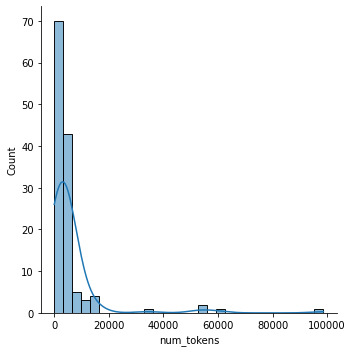

In [61]:
# Histogram based on number of tokens.

plt.figure(figsize=(8, 2))
sns.displot(df['num_tokens'], bins=30, kde=True);

# Blueprints for Word Frequency Analysis

## Blueprint: Counting Words with a Counter

In [62]:
# Counting tokens as before in HSS, but using the Counter class

from collections import Counter

counter = Counter()

# Call counter.update for each row of the column tokens. 
# Counter will be updated each time. 
_ = df['tokens'].map(counter.update) 

In [63]:
df['tokens']

0      [personal, modernist, remediations, william, j...
1      [association, computers, humanities, associati...
2      [abstract, thesis, argues, rise, sincerity, do...
3      [broaden, diversify, humanities, knowledge, tr...
4      [introduction, knowledge, models, sustaining, ...
                             ...                        
125    [foundations, canadian, humanities, social, sc...
126    [http, eludamos, making, sense, play, video, g...
127    [apex, hipster, geekdom, tei-encoded, dylan, u...
128    [care-ful, reviewer, peer, review, people, mat...
129    [ursula, guin, dispossessed, künstlerroman, tr...
Name: tokens, Length: 130, dtype: object

In [65]:
print(counter.most_common(20))

[('research', 6464), ('digital', 4408), ('social', 3352), ('open', 3281), ('humanities', 3250), ('scholarly', 3169), ('text', 3003), ('knowledge', 2815), ('university', 2548), ('work', 2527), ('also', 2449), ('blake', 2196), ('communication', 2137), ('http', 2042), ('data', 1994), ('information', 1971), ('siemens', 1877), ('https', 1873), ('access', 1761), ('project', 1725)]


In [101]:
# transform counter into data frame
min_freq = 2
freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
freq_df = freq_df.query('freq >= @min_freq')
freq_df.index.name = 'token'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(20)

,freq
token,
research,6464
digital,4408
social,3352
open,3281
humanities,3250
scholarly,3169
text,3003
knowledge,2815
university,2548


## Blueprint: Creating a Frequency Diagram

[Text(0, 0.5, 'Token'), Text(0.5, 0, 'Frequency'), Text(0.5, 1.0, 'Top Words')]

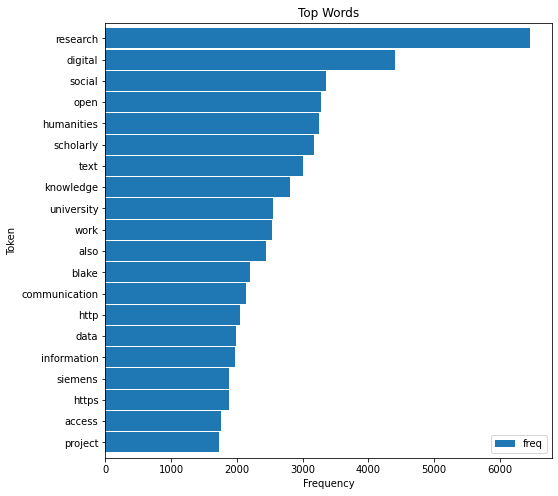

In [69]:
ax = freq_df.head(20).plot(kind='barh', width=0.95, figsize=(8,8))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

## Blueprint: Creating Word Clouds

In [78]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

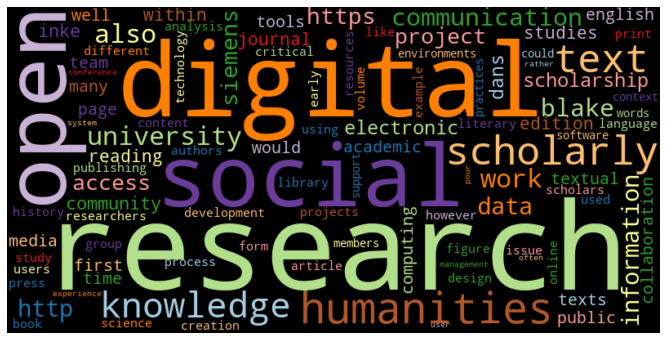

In [99]:
plt.figure(figsize=(12,6))
wordcloud(freq_df['freq'], max_words=100)

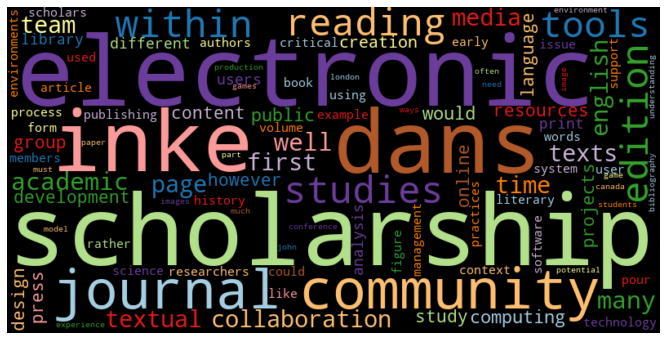

In [100]:
plt.figure(figsize=(12,6))
wordcloud(freq_df['freq'], max_words=100, stopwords=freq_df.head(20).index)

## Blueprint: Ranking with TF-IDF

In [87]:
import numpy as np

def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [88]:
idf_df = compute_idf(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [90]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

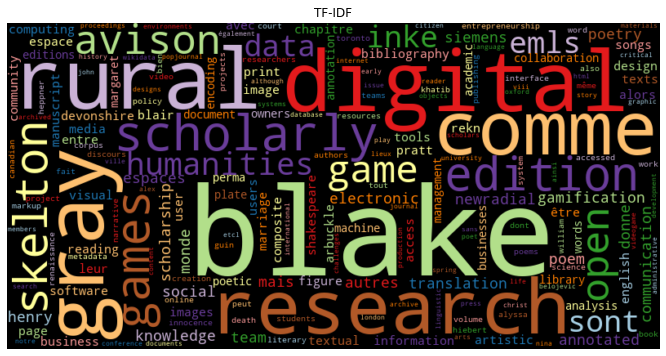

In [94]:
plt.figure(figsize=(12,6)) ###
wordcloud(freq_df['tfidf'], title='TF-IDF', stopwords=['https', 'http', 'pour', 'text', 'dans', 'elle', 'nous', 'plus', 'allc', 'cette'])